<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.883 · Aprenentatge per reforç</p>
<p style="margin: 0; text-align:right;">Màster universitari de Ciència de Dades</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# Mòdul 6: exemples d'algorismes de _TD learning_

En aquest _notebook_ carregarem alguns exemples dels algorismes de _TD learning_ vistos en el mòdul didàctic associat. 

En la primera part veurem el mètode de predicció TD(0) i després ens centrarem en SARSA i <i>Q-learning<i>. En tots els exemples emprarem l'entorn __GridWorld__ (en català, 'quadrícula') com a referència per facilitar la comparació entre mètodes i poder-nos centrar així en el desenvolupament dels algorismes.

## 1. Entorn __GridWorld__

L'entorn __GridWorld__ consisteix en un agent que es mou en una quadrícula 3 × 4. En cada pas, l'agent té quatre opcions d'acció o moviment: a dalt, a baix, a la dreta i a l'esquerra. El joc acaba quan l'agent es troba en una cel·la que no permet més moviments. Tenim dos entorns: __*standard_grid*__ i __*negative_grid*__. 

En l'entorn *standard_grid*, l'agent rep una recompensa igual a 1 quan passa per la cel·la (0,3). Per contra, quan l'agent passa per la cel·la (1,3) rep una recompensa igual a –1. 

L'entorn *negative_grid* és semblat a l'*standard_grid*, però en aquest entorn es penalitza l'agent per cada moviment que fa. És a dir, rep una recompensa negativa per cada moviment. Aquest últim entorn s'usarà per a la implementació de SARSA i <i>Q-learning</i>. 

El codi per implementar aquest entorn, que està disponible en el fitxer adjunt `gridworldgame.py`, ha estat adaptat de l'enllaç següent:
https://github.com/lazyprogrammer/machine_learning_examples/tree/master/rl

## 2. TD(0)

En aquest apartat executarem el mètode TD(0) per a l'entorn __GridWorld__ en la seva versió `standard_grid`.


En primer lloc, carregarem l'entorn __GridWorld__ i inicialitzarem els paràmetres de l'algorisme necessaris per determinar-ne la fórmula d'actualització.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gridWorldGame import standard_grid, negative_grid, print_values, print_policy

SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('O', 'D', 'L', 'R')
ALPHA = 0.1

## 2.1. Inicialització
En aquest apartat farem totes les operacions necessàries per executar l'algorisme. En primer lloc, definim un valor d'èpsilon ($\epsilon$) per a les accions aleatòries. Aquesta part del codi ens serveix per assegurar que es visitin tots els estats durant l'execució dels passos de l'algorisme (és a dir, l'exploració).

In [2]:
def random_action(a, eps=0.1):
    # epsilon-soft per assegurar que es visitin tots els estats
    p = np.random.random()
    if p < (1 - eps):
        return a
    else:
        return np.random.choice(ALL_POSSIBLE_ACTIONS)

A continuació, posicionarem el nostre agent en el seu estat inicial. Definirem també els estats, les recompenses (en anglès, _rewards_) i les accions.

In [3]:
def play_game(grid, policy):
    # retorna una llista d'estats i els rewards corresponents
    # inicia en l'estat designat
    s = (2, 0)
    grid.set_state(s)
    states_and_rewards = [(s, 0)] # llista de les parelles (estat, reward)
    while not grid.game_over():
        a = policy[s]
        a = random_action(a)
        r = grid.move(a)
        s = grid.current_state()
        states_and_rewards.append((s,r))
    
    return states_and_rewards

Per poder verificar l'entorn, podem visualitzar en la pantalla l'estructura de la nostra quadrícula (de mida 4 × 4) i els valors de recompensa associats a cada posició.

In [4]:
grid = standard_grid()

# print rewards
print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|


A continuació, definirem la política inicial i la imprimirem per visualitzar-la en la quadrícula.

In [5]:
# state -> action
policy = {
  (2, 0): 'U',
  (1, 0): 'U',
  (0, 0): 'R',
  (0, 1): 'R',
  (0, 2): 'R',
  (1, 2): 'R',
  (2, 1): 'R',
  (2, 2): 'R',
  (2, 3): 'U',
}

# política inicial
print("initial policy:")
print_policy(policy, grid)

initial policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  U  |  R  |  R  |  U  |


Seguidament, inicialitzarem els valors de $V(s)$ i els imprimirem en pantalla per poder comprovar-ne i verificar-ne el funcionament.

In [6]:
V = {}
states = grid.all_states()
for s in states:
    V[s] = 0

# inicialitzar el valor per a tots els estats en la quadrícula
print_values(V, grid)

---------------------------
 0.00| 0.00| 0.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|


## 2.2. Implementació de l'algorisme TD(0)

En aquest apartat implementarem l'algorisme TD(0), que s'executarà de manera iterativa fins a la seva convergència.

In [7]:
# número de iteracions
num_it = 1000

for it in range(num_it):
    print("Iteration {} / {}".format(it, num_it), end='\r')
    
    # genera un episodi usant pi
    states_and_rewards = play_game(grid, policy)
    
    # la primera parella (s,r) és l'estat inicial, que posem a 0
    # atès que no tenim un reward per començar de manera simple.
    # l'última parella (s,r) és l'estat terminal i el reward final.
    # el valor de l'estat terminal és 0 per definició, així que no ens interessa actualitzar-lo.
    for t in range(len(states_and_rewards) - 1):
        s, _ = states_and_rewards[t]
        s2, r = states_and_rewards[t+1]
        # actualitzarem V(s) a la fi de cada episodi
        V[s] = V[s] + ALPHA*(r + GAMMA*V[s2] - V[s])

print("\n...finished!")

Iteration 999 / 1000
...finished!


Finalment, imprimirem els valors finals i la política final.

In [8]:
print("final values:")
print_values(V, grid)

print("\nfinal policy:")
print_policy(policy, grid)

final values:
---------------------------
 0.74| 0.83| 0.96| 0.00|
---------------------------
 0.66| 0.00|-0.90| 0.00|
---------------------------
 0.56|-0.47|-0.73|-0.96|

final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  U  |  R  |  R  |  U  |


## 3. SARSA

En aquest apartat, implementarem el mètode SARSA per resoldre l'entorn __GridWorld__. 

## 3.1. Inicialització

Carregarem l'entorn __GridWorld__ i inicialitzarem els paràmetres de l'algorisme que apareixen en la seva fórmula d'actualització.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from gridWorldGame import standard_grid, negative_grid, print_values, print_policy

SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')
ALPHA = 0.1

Seguidament, necessitarem definir l'`argmax(key)` i el `max(value)`, que són variables que ens serveixen per a la implementació de l'algorisme.

In [10]:
def max_dict(d):
    # retorna l'argmax(key) i el max(value) d'un diccionari
    max_key = None
    max_val = float('-inf')
    for k, v in d.items():
        if v > max_val:
            max_val = v
            max_key = k
    
    return max_key, max_val

Igual que en l'exemple anterior, continuem amb la inicialització de les accions aleatòries.

In [11]:
def random_action(a, eps=0.1):
    # epsilon-soft per assegurar que es visitin tots els estats
    p = np.random.random()
    if p < (1 - eps):
        return a  
    else:
        return np.random.choice(ALL_POSSIBLE_ACTIONS)

En aquesta cas, utilitzarem l'entorn __*negative_grid*__, que implementa una penalització (recompensa negativa) per cada moviment. D'aquesta forma, s'indica a l'agent que ha de trobar el camí més curt per resoldre el problema (és a dir, la política òptima).

In [12]:
grid = negative_grid(step_cost=-0.1)

# imprimir rewards
print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|


## 3.2. Implementació de l'algorisme SARSA

A continuació, implementarem l'algorisme. És interessant notar que no inicialitzarem la política, sinó els valors de $Q$ més recents.

In [13]:
# inicialitzar Q(s,a)
Q = {}
states = grid.all_states()
for s in states:
    Q[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
        Q[s][a] = 0

# valors inicials de Q per a tots els estat en la quadrícula
print(Q)

{(0, 1): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (1, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 1): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (0, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (1, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (1, 3): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (0, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (0, 3): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 3): {'U': 0, 'D': 0, 'L': 0, 'R': 0}}


Ara crearem les variables `update_counts` i `update_counts_sa`, que ens serviran per saber quantes vegades actualitzarem els valors de $Q(s)$.

In [14]:
update_counts = {}
update_counts_sa = {}

for s in states:
    update_counts_sa[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
        update_counts_sa[s][a] = 1.0

En el següent codi implementarem els passos de l'algorisme SARSA, que s'executarà de manera iterativa fins a la seva convergència.

In [15]:
# repetir fins a la convergència
t = 1.0
deltes = []
num_it = 10000

for it in range(num_it):
    print("Iteration {} / {}".format(it, num_it), end='\r')
    
    if it % 100 == 0:
        t += 1e-2

    # en lloc de generar un episodi, jugarem un episodi i l'enviarem en loop, com aquí a sota

    s = (2, 0) # start state
    grid.set_state(s)

    # la primera (s,r) és l'estat inicial i val 0
    # (atès que no tenim un reward) per començar el joc de manera fàcil.
    # l'última (s,r) és l'estat terminal i el reward final.
    # el valor per l'estat terminal és 0 per definició, així que no ens importa fer una actualització.

    a = max_dict(Q[s])[0]
    a = random_action(a, eps=0.5/t)
    biggest_change = 0
    
    while not grid.game_over():
        r = grid.move(a)
        s2 = grid.current_state()

        # necessitem l'acció successiva, atès que Q(s,a) depèn de Q(s',a')
        # si s2 no està en la política, és l'estat terminal; tots els Q són 0
        a2 = max_dict(Q[s2])[0]
        a2 = random_action(a2, eps=0.5/t) # epsilon-greedy

        # actualitzarem Q(s,a) quan provem l'episodi
        alpha = ALPHA / update_counts_sa[s][a]
        update_counts_sa[s][a] += 0.005
        old_qsa = Q[s][a]
        Q[s][a] = Q[s][a] + alpha*(r + GAMMA*Q[s2][a2] - Q[s][a])
        biggest_change = max(biggest_change, np.abs(old_qsa - Q[s][a]))

        # volem saber quantes vegades actualitzem Q(s)
        update_counts[s] = update_counts.get(s,0) + 1

        # el pròxim estat serà el nou estat
        s = s2
        a = a2

    deltes.append(biggest_change)

print("\n...finished!")

Iteration 9999 / 10000
...finished!


Seguidament, imprimirem els valors de delta ($\delta$) per visualitzar la convergència de l'algorisme.

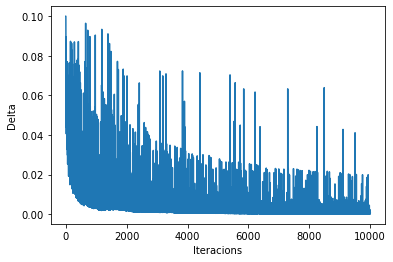

In [16]:
plt.plot(deltes)
plt.xlabel('Iteracions')
plt.ylabel('Delta')
plt.show()

En el codi següent, procedirem a determinar la política òptima a partir dels $Q$.

Per fer aquest procés, haurem de trobar els valors $V$ a partir dels valors de $Q$.

In [17]:
policy = {}
V = {}

for s in grid.actions.keys():
    a, max_q = max_dict(Q[s])
    policy[s] = a
    V[s] = max_q

Visualitzarem els $V$ per pantalla.

In [18]:
print("update counts:")
total = np.sum(list(update_counts.values()))

for k, v in update_counts.items():
    update_counts[k] = float(v) / total

print_values(update_counts, grid)

update counts:
---------------------------
 0.18| 0.18| 0.18| 0.00|
---------------------------
 0.18| 0.00| 0.04| 0.00|
---------------------------
 0.19| 0.02| 0.03| 0.00|


Per finalitzar, imprimirem els valors de $V(s)$ finals i la política trobada.

In [19]:
print("final values:")
print_values(V, grid)

print("\nfinal policy:")
print_policy(policy, grid)

final values:
---------------------------
 0.49| 0.71| 1.00| 0.00|
---------------------------
 0.29| 0.00| 0.69| 0.00|
---------------------------
 0.12| 0.20| 0.45| 0.10|

final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |


## 4. _Q-Learning_

En aquest apartat, implementarem el mètode _Q-learning_ per resoldre l'entorn __GridWorld__ (en el cas de *negative_grid*) i compararem els resultats obtinguts amb el mètode que hem implementat en l'apartat anterior (el mètode SARSA).

## 4.1. Inicialització

Carregarem l'entorn __GridWorld__ i inicialitzarem els paràmetres de l'algorisme i de les seves regles d'actualització.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from gridWorldGame import standard_grid, negative_grid,print_values, print_policy

SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')
ALPHA = 0.1

Com en el cas anterior de l'algorisme SARSA, definim l'`argmax(key)` i el `max(value)`, que són variables que ens serveixen per a la implementació de l'algorisme.

In [21]:
def max_dict(d):
    # retorna l'argmax(key) i el max(value) d'un diccionari
    max_key = None
    max_val = float('-inf')
    for k, v in d.items():
        if v > max_val:
            max_val = v
            max_key = k
    
    return max_key, max_val

Inicialitzem les accions aleatòries.

In [22]:
def random_action(a, eps=0.1):
    # epsilon-soft per assegurar que es visiten tots els estats
    p = np.random.random()
    if p < (1 - eps):
        return a  
    else:
        return np.random.choice(ALL_POSSIBLE_ACTIONS)

Igual que en l'exemple anterior, utilitzarem l'entorn __*negative_grid*__, que implementa una penalització per cada moviment. D'aquesta forma, l'agent buscarà el camí més curt per resoldre el problema (és a dir, la política òptima).

In [23]:
grid = negative_grid(step_cost=-0.1)

# imprimir rewards
print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|


## 4.2. Implementació de l'algorisme _Q-Learning_

Ara implementarem l'algorisme. Com en el cas anterior de la implementació de l'algorisme SARSA, tampoc inicialitzarem la política, sinó que inicialitzarem emprant els valors de $Q$ més recents.

In [24]:
# inicialitzar Q(s,a)
Q = {}
states = grid.all_states()

for s in states:
    Q[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
        Q[s][a] = 0

# valors inicials de Q values per a tots els estats de la quadrícula
print(Q)

{(0, 1): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (1, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 1): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (0, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (1, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (1, 3): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (0, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (0, 3): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0}, (2, 3): {'U': 0, 'D': 0, 'L': 0, 'R': 0}}


Creem les variables `update-counts` i `update_counts_sa`, que ens serviran per saber quantes vegades actualitzarem els valors de $Q(s)$.

In [25]:
update_counts = {}
update_counts_sa = {}

for s in states:
    update_counts_sa[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
        update_counts_sa[s][a] = 1.0

Com es pot veure, fins a aquest punt no es poden observar diferències respecte a l'algorisme SARSA presentat en la secció anterior.

A continuació, implementarem els passos de l'algorisme _Q-learning_ fins a la seva convergència. És important notar les diferències, aquí sí, respecte a l'exemple mostrat en la secció anterior.

In [26]:
# repetir fins a la convergència
t = 1.0
deltes = []
num_it = 10000

for it in range(num_it):
    print("Iteration {} / {}".format(it, num_it), end='\r')
    
    if it % 100 == 0:
        t += 1e-2

    # en lloc de generar un episodi, jugarem un episodi i l'enviarem en loop, com aquí a sota

    s = (2, 0) # estat inicial
    grid.set_state(s)

    # la primera (s,r) és l'estat inicial i val 0 
    # (atès que no tenim un reward) per començar el joc de manera fàcil.
    # l'última (s,r) és l'estat terminal i el reward final.
    # el valor per l'estat terminal és 0 per definició, així que no ens importa fer una actualització.

    a, _ = max_dict(Q[s])
    biggest_change = 0
    while not grid.game_over():
        a = random_action(a, eps=0.5/t) # epsilon-greedy
        # una acció random també funciona, però seria mes lenta atès que podríem topar contra els murs
        # a = np.random.choice(ALL_POSSIBLE_ACTIONS)
        r = grid.move(a)
        s2 = grid.current_state()

        # adaptive learning rate
        alpha = ALPHA / update_counts_sa[s][a]
        update_counts_sa[s][a] += 0.005

        # actualitzarem Q(s,a) cada vegada que provem un episodi
        old_qsa = Q[s][a]
        # la diferència entre SARSA i Q-Learning és que Q-Learning
        # usa max[a']{ Q(s',a')} en l'actualització
        # encara que no acabarem fent aquella acció en el pas següent
        a2, max_q_s2a2 = max_dict(Q[s2])
        Q[s][a] = Q[s][a] + alpha*(r + GAMMA*max_q_s2a2 - Q[s][a])
        biggest_change = max(biggest_change, np.abs(old_qsa - Q[s][a]))

        # volem saber quantes vegades actualitzem Q(s)
        update_counts[s] = update_counts.get(s,0) + 1

        # el pròxim estat serà el nou estat
        s = s2
        a = a2
   
    deltes.append(biggest_change)

print("\n...finished!")

Iteration 966 / 10000

Iteration 9999 / 10000
...finished!


Imprimirem els valors de delta ($\delta$) per visualitzar la convergència de l'algorisme.

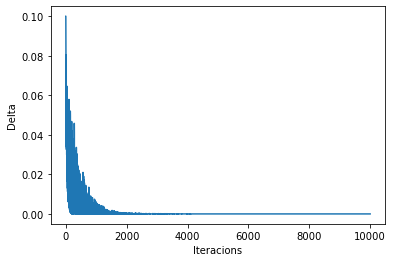

In [27]:
plt.plot(deltes)
plt.xlabel('Iteracions')
plt.ylabel('Delta')
plt.show()

Ara podem determinar la política òptima a partir de $Q$. Per fer aquest pas, haurem de trobar $V$ a partir de $Q$. 

Aquests passos són, de nou, semblants als utilitzats en la implementació de l'algorisme SARSA.

In [28]:
# determinar la política a partir de Q*
# trobar V* des de Q*
policy = {}
V = {}

for s in grid.actions.keys():
    a, max_q = max_dict(Q[s])
    policy[s] = a  
    V[s] = max_q

Visualitzem els valors de $V$:

In [29]:
print("update counts:")
total = np.sum(list(update_counts.values()))

for k, v in update_counts.items():
    update_counts[k] = float(v) / total

print_values(update_counts, grid)

update counts:
---------------------------
 0.03| 0.04| 0.16| 0.00|
---------------------------
 0.02| 0.00| 0.16| 0.00|
---------------------------
 0.19| 0.19| 0.18| 0.02|


Finalment, podem imprimir els valors de $V(s)$ finals i la política trobada.

In [30]:
print("final values:")
print_values(V, grid)

print("\nfinal policy:")
print_policy(policy, grid)

final values:
---------------------------
 0.62| 0.80| 1.00| 0.00|
---------------------------
 0.46| 0.00| 0.80| 0.00|
---------------------------
 0.31| 0.46| 0.62| 0.46|

final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  R  |  R  |  U  |  L  |
